In [1]:
import math
import solvers as sv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

# Implementation

## Mathematics

The underlying mathematics used to solve the Lotka-Volterra model is defined as follows *(Wikipedia Contributors, 2023)*: 

$\frac{dx}{dt} = \alpha x - \beta xy + f(t) \\$
$\frac{dy}{dt} = \gamma xy - \delta y + g(t) $

Where $x$ represents prey and $y$ predator.

For each model we have defined $t_{final} = T$ the final time along with $t_0$ the inital time and $y_0$ the inital condition. We have also defined the two external migration functions $f(t)$ and $g(t)$ and the values for $\alpha$, $\beta$, $\gamma$ and $\delta$. Finally for model $A$ we have also defined the exact solution.

## Model $A$

$\alpha = 1 \\$
$\beta = 1 \\$
$\gamma = 1 \\$
$\delta = 1 \\$
$f(t) = - sin(t) - (cos(t))^2 - cos(t) \\$
$g(t) = sin(t) + (cos(t))^2 - cos(t) \\$
$t_0 = 0 \\$
$y_0 = [2, 0] \\$
$T = 2.5 \pi $

### Exact solution

$x(t) = 1 + cos(t) \\$
$y(t) = 1 - cos(t) $

## Model $B$

$\alpha = \frac{2}{3} \\$
$\beta = \frac{4}{3} \\$
$\gamma = 1 \\$
$\delta = 1 \\$
$f(t) = 0 \\$
$g(t) = 0 \\$
$t_0 = 0 \\$
$y_0 = [0.9, 0.9] \\$
$T = 30 $

The methods chosen to solve the pair of first-order nonlinear differential equations is as follows:

- Euler's formula (Implemented)
- SSPRK3 (Solvers)
- 3/8 Rule (Solvers)

Each model and method is computed at each of the step sizes, defined as:

- $T/100$
- $T/200$
- $T/400$
- $T/800$
- $T/1600$

In [2]:
# Base model from which model A and B can be derived
class Model(object):
    # Method for computing dx of a given model
    @staticmethod
    def dx(model, x: np.float64, y: np.float64, t: np.float64) -> np.float64:
        return np.float64(model.alpha * x - model.beta * x * y + model.f(t))

    # Method for computing dy of a given model
    @staticmethod
    def dy(model, x: np.float64, y: np.float64, t: np.float64) -> np.float64:
        return np.float64(model.delta * x * y - model.gamma * y + model.g(t))

    # Method for computing the rhs value of a given model
    @staticmethod
    def rhs(model, t: np.float64, y: np.array) -> np.array:
        return np.array(
            [Model.dx(model, y[0], y[1], t), Model.dy(model, y[0], y[1], t)],
            dtype=np.float64,
        )

In [3]:
# Model containing data pretaining to model A
class ModelA(Model):
    # Values and starting conditions
    alpha: np.float64 = np.float64(1)
    beta: np.float64 = np.float64(1)
    gamma: np.float64 = np.float64(1)
    delta: np.float64 = np.float64(1)
    y0: np.array = np.array([2, 0], dtype=np.float64)
    t0: np.float64 = np.float64(0)
    T: np.float64 = np.float64(2.5 * math.pi)

    # Method for calculating exact t(t)
    @staticmethod
    def x(t: np.float64) -> np.float64:
        return np.float64(1 + math.cos(t))

    # Method for calculating exact y(t)
    @staticmethod
    def y(t: np.float64) -> np.float64:
        return np.float64(1 - math.cos(t))

    # Method for calculating f(t)
    @staticmethod
    def f(t: np.float64) -> np.float64:
        return np.float64(-math.sin(t) - math.pow(math.cos(t), 2) - math.cos(t))

    # Method for calculating g(t)
    @staticmethod
    def g(t: np.float64) -> np.float64:
        return np.float64(math.sin(t) + math.pow(math.cos(t), 2) - math.cos(t))

    # Method for calculating the rhs value for model A
    @staticmethod
    def rhs(t: np.float64, y: np.array) -> np.array:
        return Model.rhs(ModelA, t, y)

In [4]:
# Model containing data pretaining to model B
class ModelB(Model):
    # Values and starting conditions
    alpha: np.float64 = np.float64(2 / 3)
    beta: np.float64 = np.float64(4 / 3)
    gamma: np.float64 = np.float64(1)
    delta: np.float64 = np.float64(1)
    y0: np.array = np.array([0.9, 0.9], dtype=np.float64)
    t0: np.float64 = np.float64(0)
    T: np.float64 = np.float64(30)

    # Method for calculating f(t)
    @staticmethod
    def f(t: np.float64) -> np.float64:
        return np.float64(0)

    # Method for calculating g(t)
    @staticmethod
    def g(t: np.float64) -> np.float64:
        return np.float64(0)

    # Method for calculating the rhs value for model B
    @staticmethod
    def rhs(t: np.float64, y: np.array) -> np.array:
        return Model.rhs(ModelB, t, y)

In [5]:
# Method to compute eulers on a given models inputs
def eulers(
    rhs, y0: np.array, t0: np.float64, dt: np.float64, T: np.float64
) -> [np.array, np.ndarray]:
    # Calculate n to find the number of iterations to complete
    n: np.int64 = np.int64(math.ceil(T / dt))

    # Define arrays to store the output
    output = np.zeros(shape=(n + 1, y0.size), dtype=np.float64)
    times = np.zeros(shape=(n + 1), dtype=np.float64)

    # Define the inital conditions
    output[0] = y0
    times[0] = t0

    # Compute each iteration
    for index in range(1, n + 1):
        output[index] = output[index - 1] + dt * rhs(
            times[index - 1], output[index - 1]
        )
        times[index] = times[index - 1] + dt

    return [times, output]

In [6]:
def exact(model: object, time_values: np.array) -> [np.array, np.array, np.float64]:
    # Define arrays to store the output
    output_prey = np.zeros(shape=time_values.size, dtype=np.float64)
    output_predator = np.zeros(shape=time_values.size, dtype=np.float64)

    # Start computation timer
    start_time = timeit.default_timer()

    # Compute each iteration
    for index in range(0, time_values.size):
        output_prey[index] = model.x(time_values[index])
        output_predator[index] = model.y(time_values[index])

    # End computation timer and record time
    output_time = timeit.default_timer() - start_time

    return [output_prey, output_predator, output_time]

In [7]:
def solve(
    model: object, dt_scalar: np.float64, algorithm: str
) -> [np.array, np.array, np.array, np.float64]:
    # Calcualte the dt value for the given model and scalar
    dt = model.T * dt_scalar

    # Start computation timer
    start_time = timeit.default_timer()

    # Compute output
    if algorithm == "Eulers":
        t, y = eulers(model.rhs, model.y0, model.t0, dt, model.T)
    else:
        t, y = sv.solver(model.rhs, model.y0, model.t0, dt, model.T, algorithm)

    # End computation timer and record time
    output_time = timeit.default_timer() - start_time

    # Parse into multiple one dimensional arrays
    prey_values = np.array([xy[0] for xy in y], dtype=np.float64)
    predator_values = np.array([xy[1] for xy in y], dtype=np.float64)
    time_values = np.array(t, dtype=np.float64)

    return [prey_values, predator_values, time_values, output_time]

In [8]:
# Definition for the models, algorithms, dt scalars and number of runs to calculate the average computation time
models = np.array([ModelA, ModelB], dtype=object)
algorithms = np.array(["3/8-rule", "SSPRK3", "Eulers"], dtype=object)
dt_scalars = np.array([1 / 100, 1 / 200, 1 / 400, 1 / 800, 1 / 1600], dtype=np.float64)
dt_scalar_names = np.array(["T/100", "T/200", "T/400", "T/800", "T/1600"], dtype=object)
computation_time_runs = 10

# Create multi dimensional arrays to store computation times
computation_times = np.zeros(
    shape=(models.size, algorithms.size, dt_scalars.size, computation_time_runs),
    dtype=np.float64,
)
computation_times_exact = np.zeros(
    shape=(dt_scalars.size, computation_time_runs),
    dtype=np.float64,
)

# Create multi dimensional arrays to store all outputs
values = []
exacts = []

In [9]:
# Method to run calculations on a specific model, algorithm and dt_scalar
def run(model, model_index, algorithm, algorithm_index, dt_scalar, dt_scalar_index):
    # Loop for number of runs to create array for average computation time
    for index in range(0, computation_time_runs):
        # Get the output for the specific run
        prey_values, predator_values, time_values, computation_time = solve(
            model, dt_scalar, algorithm
        )

        # Populate the computation time entry
        computation_times[model_index][algorithm_index][dt_scalar_index][
            index
        ] = computation_time

        # Population the values array if neccessary
        if index == 0:
            values[model_index][algorithm_index][dt_scalar_index][0] = prey_values
            values[model_index][algorithm_index][dt_scalar_index][1] = predator_values
            values[model_index][algorithm_index][dt_scalar_index][2] = time_values

        # Check for model A and calculate exact solution
        if model_index == 0 and algorithm_index == 0:
            # Get the exact values
            prey_exact, predator_exact, computation_time = exact(model, time_values)

            # Populate the computation time entry
            computation_times_exact[dt_scalar_index][index] = computation_time

            # Population the exacts array if neccessary
            if index == 0:
                exacts[dt_scalar_index][0] = prey_exact
                exacts[dt_scalar_index][1] = predator_exact


# Method to run calculations on each model, algorithm and dt scalar
def compute():
    for model_index, model in enumerate(models):
        values.append([])
        for algorithm_index, algorithm in enumerate(algorithms):
            values[model_index].append([])
            for dt_scalar_index, dt_scalar in enumerate(dt_scalars):
                values[model_index][algorithm_index].append([])
                values[model_index][algorithm_index][dt_scalar_index].append([])
                values[model_index][algorithm_index][dt_scalar_index].append([])
                values[model_index][algorithm_index][dt_scalar_index].append([])

                exacts.append([])
                exacts[dt_scalar_index].append([])
                exacts[dt_scalar_index].append([])

                run(
                    model,
                    model_index,
                    algorithm,
                    algorithm_index,
                    dt_scalar,
                    dt_scalar_index,
                )

In [10]:
colors = ["#ffff00", "#00ffff", "#ff00ff", "#00ff00", "#ff0000", "#0000ff"]


def graph_absolute_errors():
    figure_a, plots_a = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8, 4))
    graph_absolute_error(plots_a[0], 0)
    graph_absolute_error(plots_a[1], 1)
    graph_absolute_error(plots_a[2], 2)
    plt.tight_layout()
    plt.yscale(value="log")
    plt.xscale(value="log")
    figure_a.dpi = 300


def graph_absolute_error(plot, algorithm_index):
    # Plot data
    for dt_scalar_index in range(0, dt_scalars.size):
        plot.plot(
            np.absolute(
                values[0][algorithm_index][dt_scalar_index][0]
                - exacts[dt_scalar_index][0]
            )[1:],
            np.absolute(
                values[0][algorithm_index][dt_scalar_index][1]
                - exacts[dt_scalar_index][1]
            )[1:],
            linewidth=np.float64(0.75),
            color=colors[dt_scalar_index],
            label=dt_scalar_names[dt_scalar_index],
        )
    # Style graph
    plot.set_title(
        f"Absolute error for model A\nwhen using {algorithms[algorithm_index]}",
        loc="center",
        wrap=True,
    )
    plot.set_ylabel("Population density error (predator) [logarithmic]")
    plot.set_xlabel("Population density error (prey)\n[logarithmic]")
    plot.legend(loc="upper left")


def graph_average_computation_times():
    figure, plots = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
    graph_average_computation_time(plots[0], 0, "A")
    graph_average_computation_time(plots[1], 1, "B")
    plt.tight_layout()
    figure.dpi = 300


def graph_average_computation_time(plot, model_index, model_name):
    # Plot data
    for line_index in range(0, algorithms.size):
        plot.plot(
            dt_scalars,
            [
                np.average(dt_scalar_computation_times)
                for dt_scalar_computation_times in computation_times[model_index][
                    line_index
                ]
            ],
            linewidth=np.float64(0.75),
            color=colors[line_index],
            label=algorithms[line_index],
        )
    if model_index == 0:
        plot.plot(
            dt_scalars,
            [
                np.average(dt_scalar_computation_times_exact)
                for dt_scalar_computation_times_exact in computation_times_exact
            ],
            linewidth=np.float64(0.75),
            color=colors[algorithms.size],
            label="Exact",
        )
    # Style graph
    plot.set_title(
        f"Average compuation time for model {model_name}\nover {computation_time_runs} runs at each value of dt",
        loc="center",
        wrap=True,
    )
    plot.set_ylabel("Computation time (seconds)")
    plot.set_xlabel("dt value")
    plot.set_xticks(
        dt_scalars,
        labels=["T/100", "T/200", "T/400", "T/800", "T/1600"],
        rotation="vertical",
    )
    plot.invert_xaxis()
    plot.legend(loc="upper left")


def graph_model_outputs():
    figure_a, plots_a = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    graph_model_a_output(plots_a[0, 0], 2, 0, "T/100")
    graph_model_a_output(plots_a[0, 1], 2, 4, "T/1600")
    graph_model_a_output(plots_a[1, 0], 0, 0, "T/100")
    graph_model_a_output(plots_a[1, 1], 1, 0, "T/100")
    plt.tight_layout()
    figure_a.dpi = 300
    figure_b, plots_b = plt.subplots(ncols=2, figsize=(8, 3))
    graph_model_b_output(plots_b[0], 0, "T/100")
    graph_model_b_output(plots_b[1], 4, "T/1600")
    plt.tight_layout()
    figure_b.dpi = 300


def graph_model_b_output(plot, dt_scalar_index, dt_scalar_name):
    # Plot data
    for line_index in range(0, algorithms.size):
        plot.plot(
            values[1][line_index][dt_scalar_index][0],
            values[1][line_index][dt_scalar_index][1],
            linewidth=np.float64(0.75),
            color=colors[line_index],
            label=algorithms[line_index],
        )
    # Style graph
    plot.set_title(
        f"Output for model B when dt={dt_scalar_name}",
        loc="center",
        wrap=True,
    )
    plot.set_ylabel("Population density (predator)")
    plot.set_xlabel("Population density (prey)")
    plot.legend(loc="upper left")


def graph_model_a_output(plot, algorithm_index, dt_scalar_index, dt_scalar_name):
    labels = ["Prey", "Predator"]
    # Plot data
    for index in range(0, 2):
        plot.plot(
            values[0][algorithm_index][dt_scalar_index][2],
            values[0][algorithm_index][dt_scalar_index][index],
            linewidth=np.float64(0.75),
            color=colors[index],
            label=labels[index],
        )
    # Style graph
    plot.set_title(
        f"Output for model A using {algorithms[algorithm_index]}\nwhen dt={dt_scalar_name}",
        loc="center",
        wrap=True,
    )
    plot.set_ylabel("Population density")
    plot.set_xlabel("Time")
    plot.legend(loc="upper left")


def table_model_a_output():
    df = pd.DataFrame(
        data=np.transpose(
            [
                values[0][0][0][2][0:],
                exacts[0][0][0:],
                values[0][0][0][0][0:],
                values[0][1][0][0][0:],
                values[0][2][0][0][0:],
                exacts[0][1][0:],
                values[0][0][0][1][0:],
                values[0][1][0][1][0:],
                values[0][2][0][1][0:],
            ]
        ),
        columns=[
            "Time",
            "Exact (prey)",
            "3/8-rule (prey)",
            "SSPRK3 (prey)",
            "Eulers (prey)",
            "Exact (predator)",
            "3/8-rule (predator)",
            "SSPRK3 (predator)",
            "Eulers (predator)",
        ],
    )
    return df

In [11]:
compute()

# Results

To display a wide range of information a very specific set of graphs have been produced. For model $A$ each algorithm has been given a graph apart from Euler's method which has one for $T/100$ and one for $T/1600$, this shows how Euler's method changes as the step size decreases. 

For model $B$ all three algorithms have been combined onto a single graph where time is represented in a circular motion, again two graphs, one for $T/100$ and one for $T/1600$ have been produced.

For computation time two graphs have been produced, one for model $A$ the other for model $B$. The iterations have been combined into a single average line.

Finally the absolute error for model $A$ has been graphed across three different plots, one for each algorithm. Each plot has all the time step sizes and is shown on a logarithmic scale. Along with this the first entry $t_0$ has been removed as this value is always exact.

,Time,Exact (prey),3/8-rule (prey),SSPRK3 (prey),Eulers (prey),Exact (predator),3/8-rule (predator),SSPRK3 (predator),Eulers (predator)
0,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
1,0.078540,1.996917,1.996917,1.996933,2.000000,0.003083,0.003083,0.003079,0.000000
2,0.157080,1.987688,1.987689,1.987722,1.994563,0.012312,0.012312,0.012305,0.005921
3,0.235619,1.972370,1.972370,1.972422,1.983812,0.027630,0.027630,0.027621,0.017715
4,0.314159,1.951057,1.951057,1.951129,1.967896,0.048943,0.048943,0.048932,0.035308
5,0.392699,1.923880,1.923881,1.923973,1.946991,0.076120,0.076120,0.076107,0.058606
6,0.471239,1.891007,1.891008,1.891122,1.921290,0.108993,0.108993,0.108979,0.087498
7,0.549779,1.852640,1.852642,1.852777,1.890996,0.147360,0.147359,0.147345,0.121858
8,0.628319,1.809017,1.809019,1.809175,1.856316,0.190983,0.190983,0.190970,0.161554
9,0.706858,1.760406,1.760408,1.760584,1.817447,0.239594,0.239594,0.239584,0.206449


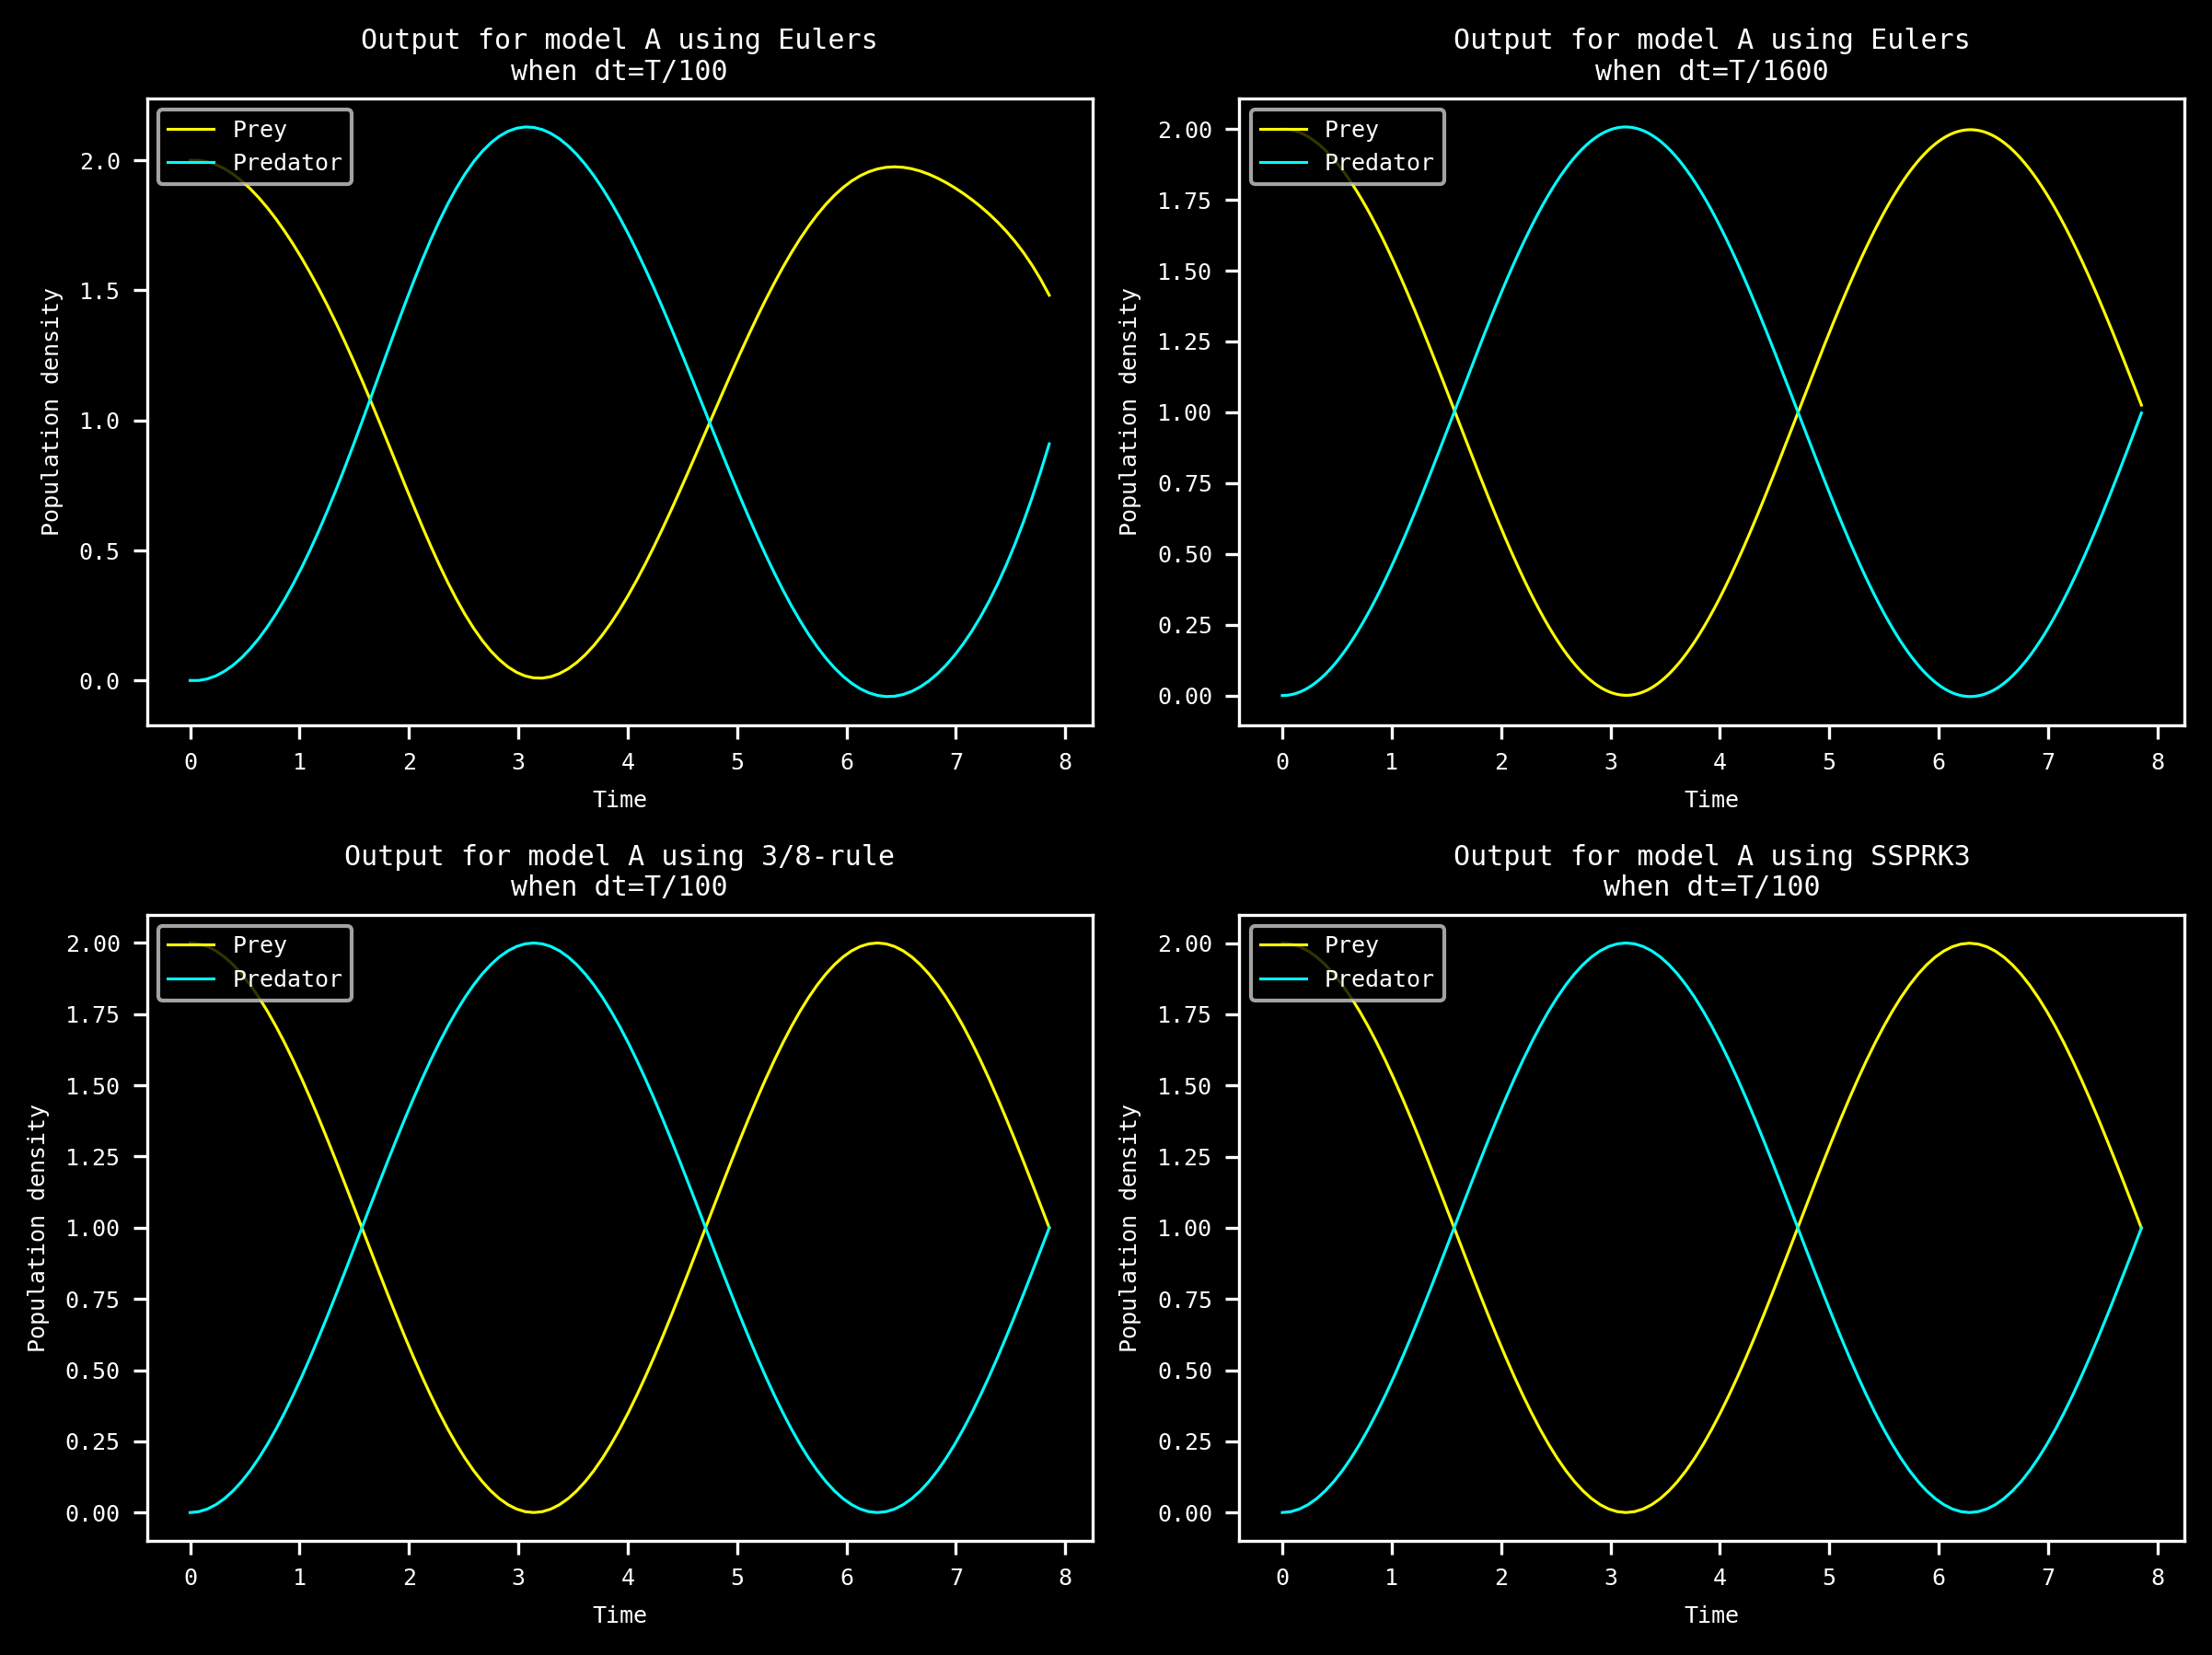

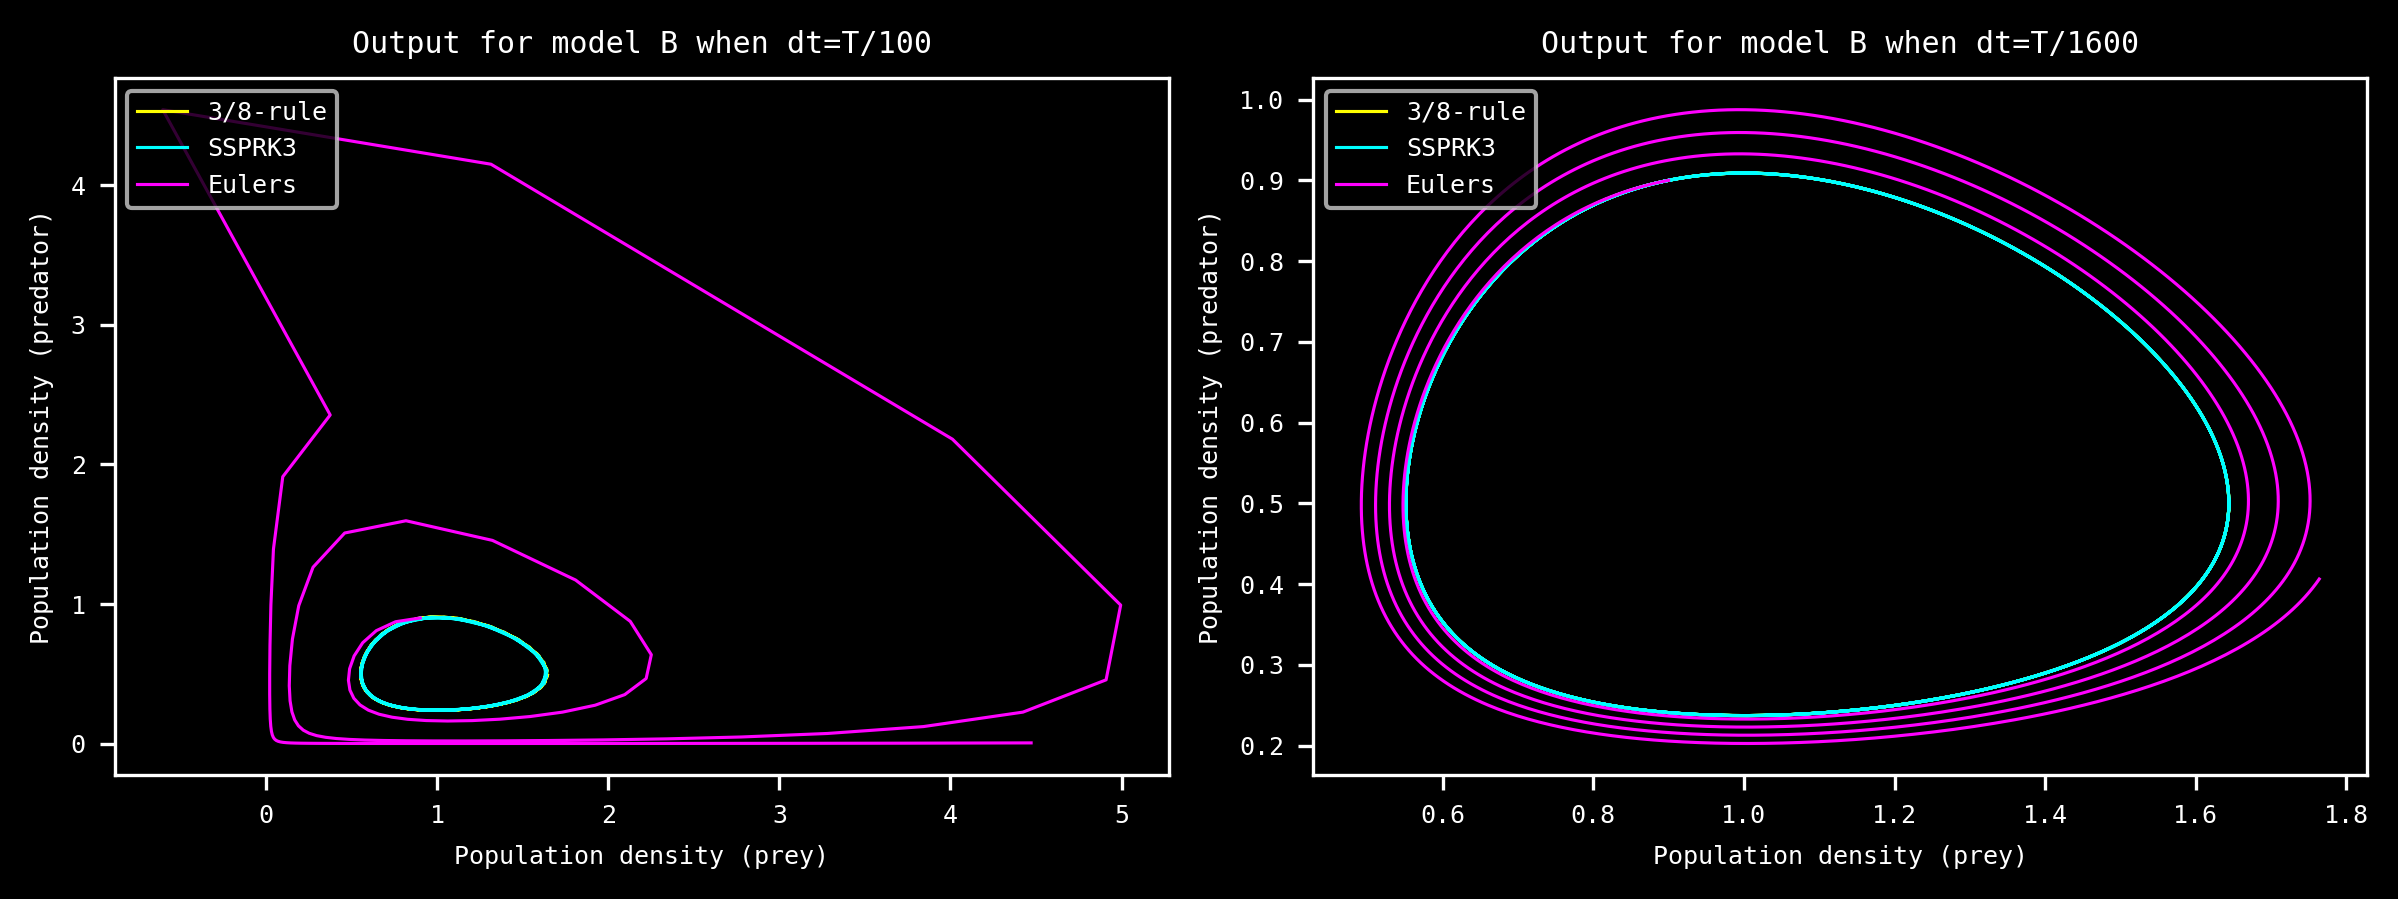

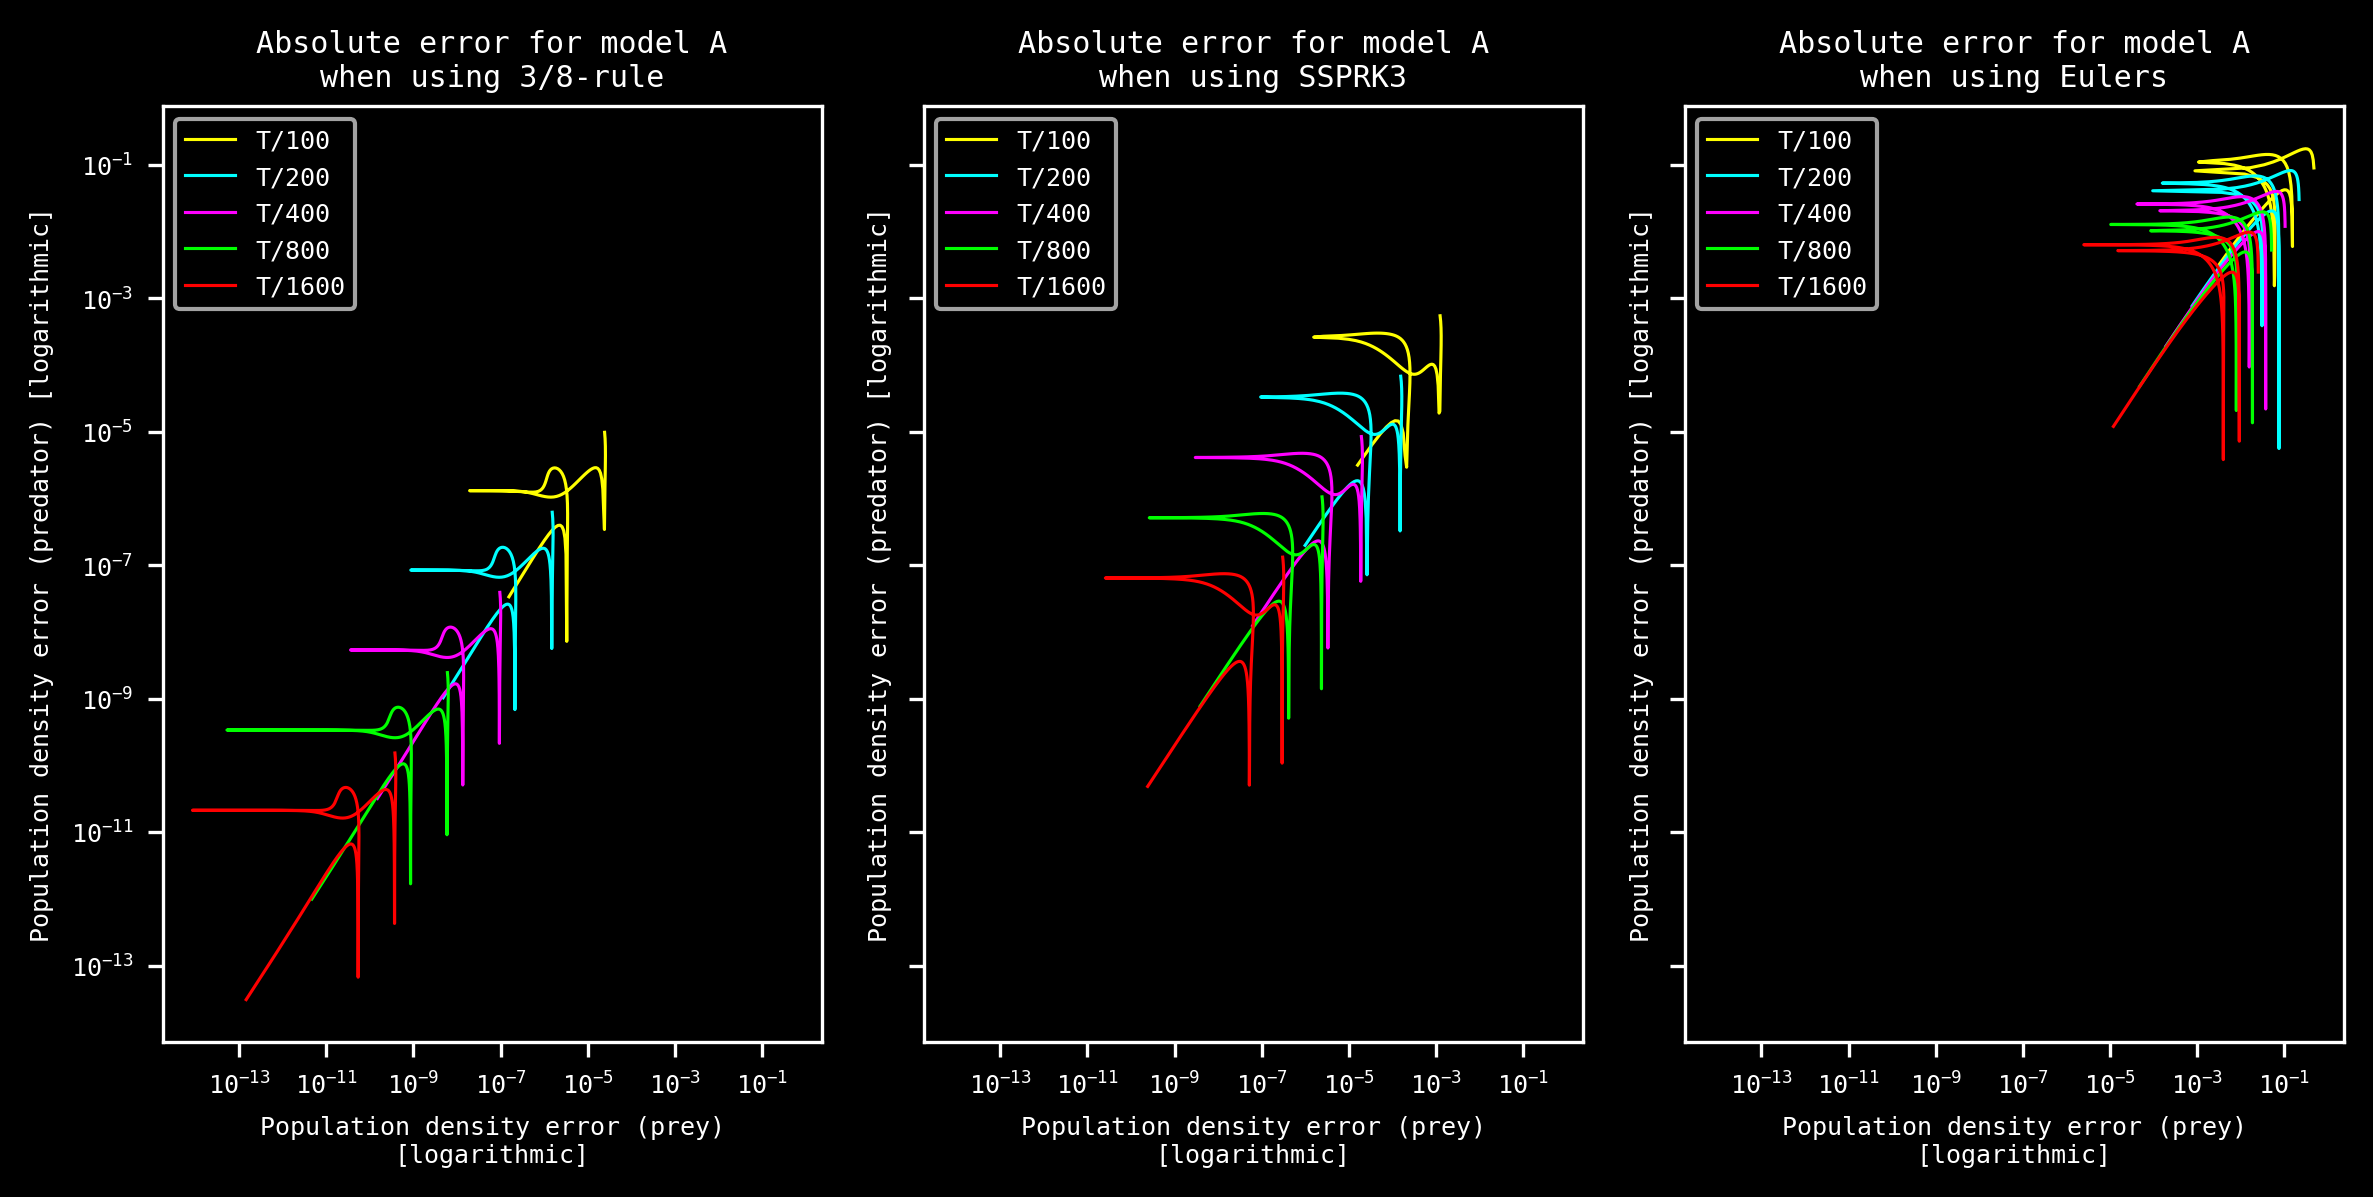

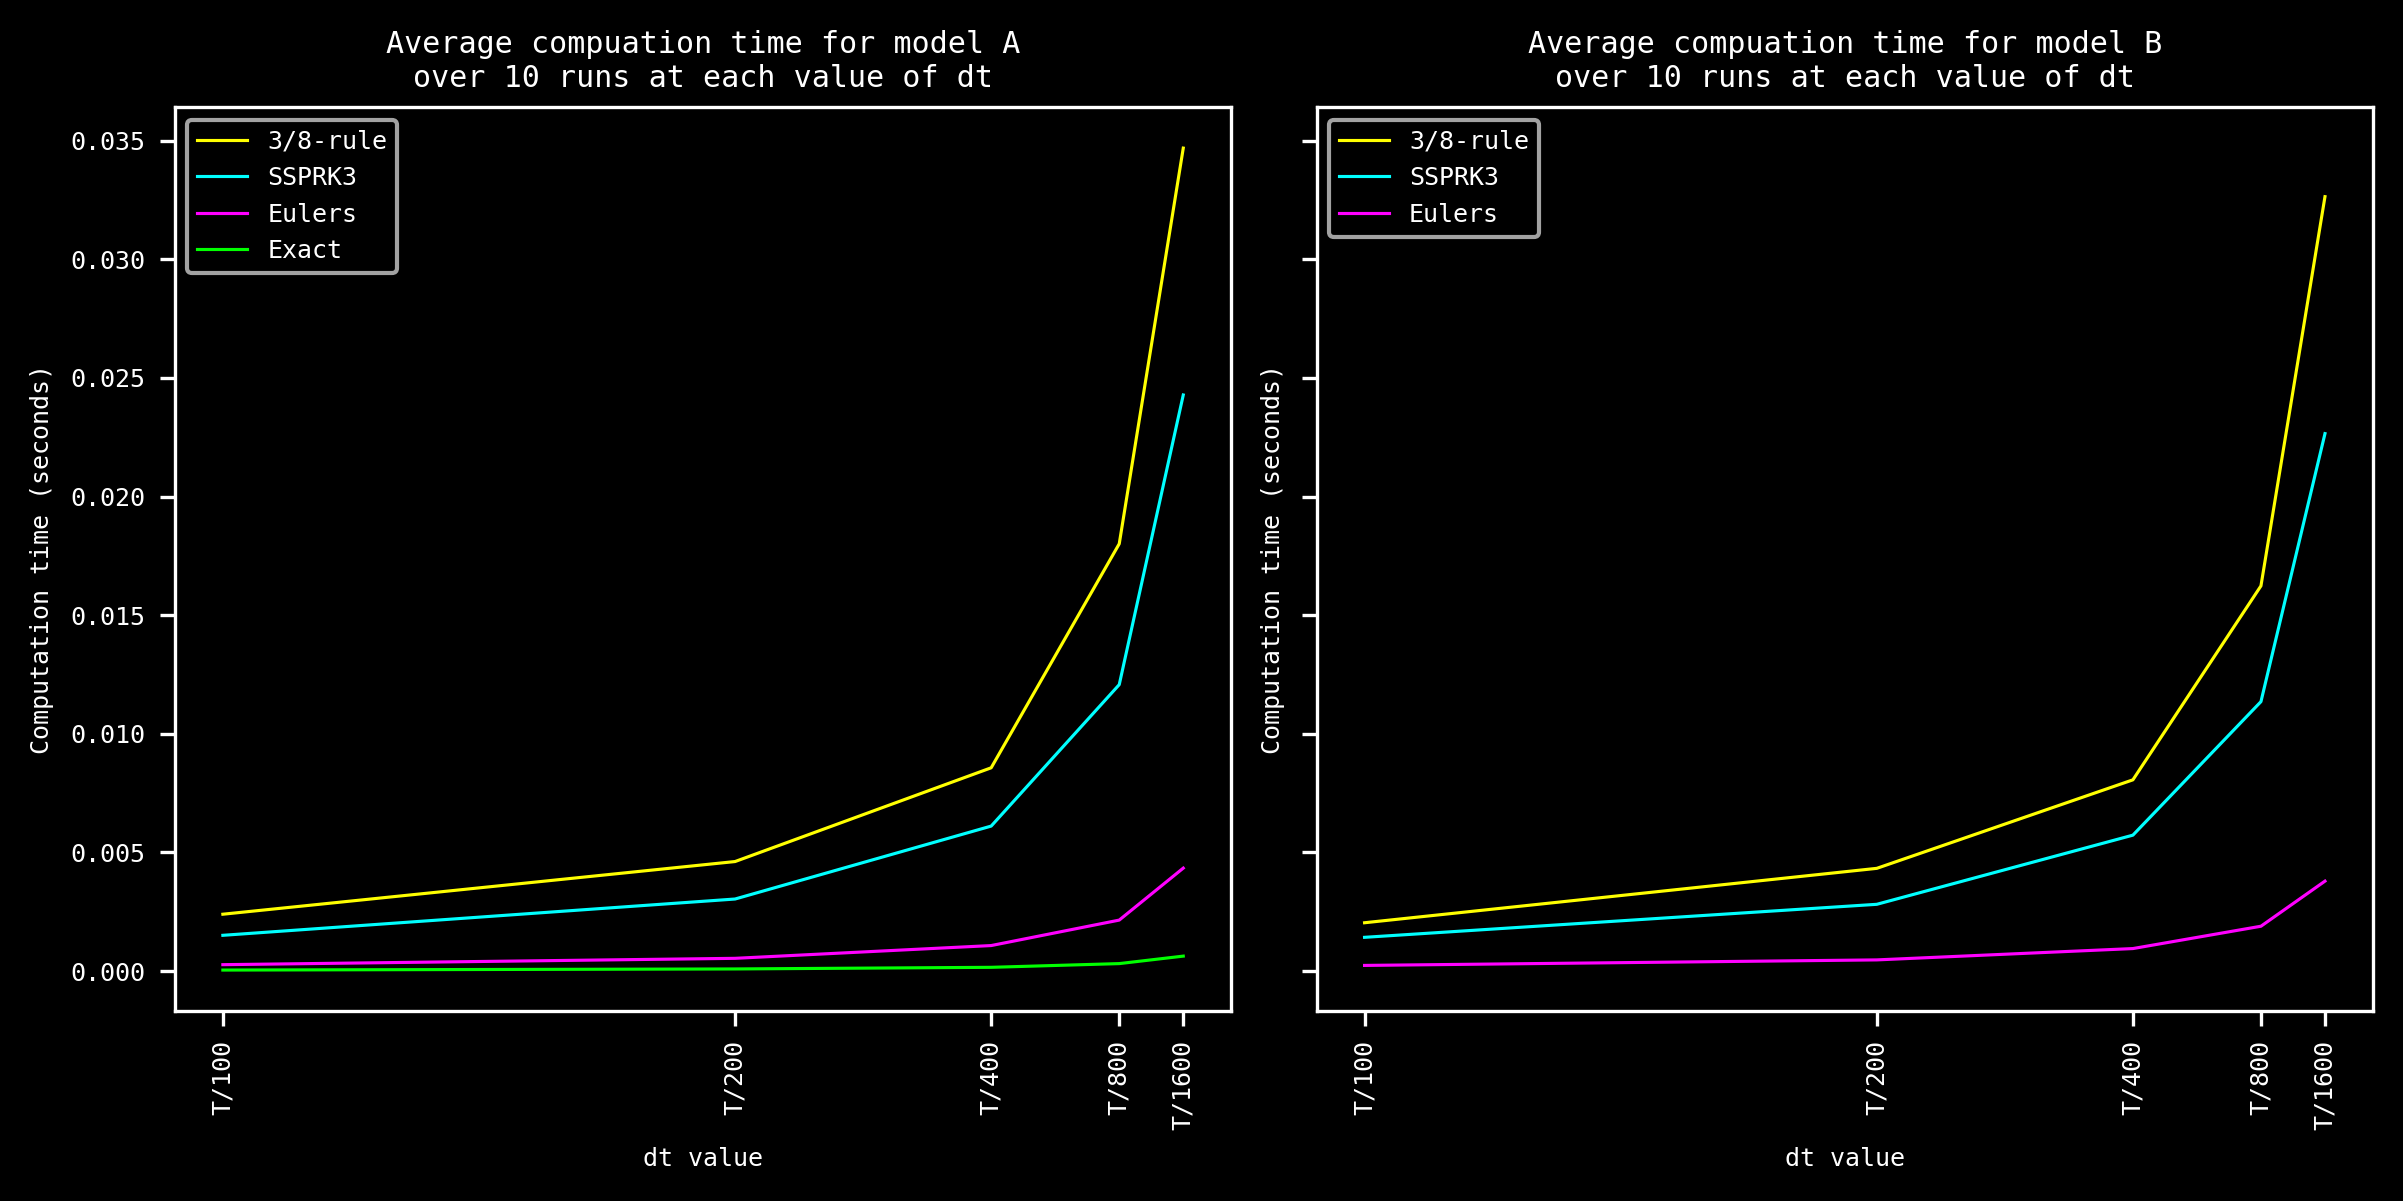

In [12]:
plt.style.use("dark_background")
plt.rcParams.update({"font.family": "monospace"})
plt.rcParams.update({"font.size": 6})

graph_model_outputs()
graph_absolute_errors()
graph_average_computation_times()
df = table_model_a_output()
df.head(15).style.set_caption("Output for model A when dt=T/100")

# Analysis

## Euler's method

Euler's method is one of the simplest and oldest methods for approximating differential equations *(Jain et al., 2023)*. This method is a first order accurate method.

Without looking at the data for absolute error we can immediatley see that Euler's method heavily diverges from the other two algorithms presented, this is most prominent in the graph titled `Output for model B when dt=T/100`. The difference is however less noticeable in model $A$ especially as the step size decreases.

When we look at the data for absolute error we see that Euler's method produces extremely high error compared with the other algorithms presented. While Euler's method does produce less error as the step size decreases it still tends to be more inacurate than SSPRK3 and the 3/8 Rule.

Due to Euler's methods simplistic nature it is the least computationally intensive, however as the step size decreases further it is likely that all the algroithms will tend exponentially leading to less seperation in computation time.

## SSPRK3

SSP-RK 3 (Strong-Stability Preserving Runge-Kutta 3) is a three stage modification of the Runge-Kutta method which aims to preserve certain stability properties of the underlying system once it has been approximated *(Durran, 2010)*. This method has a third order accuracy. 

SSPRK3 produces much more accurate results than Euler's method but is still beaten by the 3/8 Rule. It produces a minimal amount of error when compared with Euler's however once it is scaled up against the 3/8 Rule we can see that SSPRK3 still tends to produce a much higher amount of error, all be it at a very small scale with a maximum absolute error of around $1.4e-3$.

For both models SSPRK3 takes longer to compute than Euler's method. It can also be shown to be on a much steeper exponential trajectory than Euler's method as the step size decreases. However, SSPRK3 is still faster to compute than the 3/8 Rule even despite it's strong-stability preserving properties.

## 3/8 Rule

The 3/8 Rule is a varient of the more general Simpson's Rule. Instead of making use of a second order (quadratic) polynomial like Simpons's 1/3 Rule it makes use of a third order (cubic) polynomial, this allows the 3/8 Rule to be about twice as accurate *(freeCodeCamp, 2020)*. The method has a fourth order accuracy.

The 3/8 Rule produces by far the most accurate results with a maximum absolute error of around $2.5e-5$. This is most likely due to the fact that 3/8 Rule is of a fourth order accuracy so produces much better results.

The 3/8 Rule however is the most computationally intensive algorithm taking the longest time to compute. The difference in computation time between 3/8 Rule and SSPRK3 can however be seen as neglibible in most cases, espsially as the step size decreases.

# Conclusion

Using the current provided models Euler's method produces the most innacurate results with SSPRK3 and the 3/8 Rule producing much more accurate results. The 3/8 Rule wins on accuracy overall with an extremely low maximum absolute error of around $2.5e-5$. For model $A$ the most efficient way to compute the results would be to use the exact solution, introducing no error, as not even Euler's method is more efficient. For model $B$ however this may not be the case.

Euler's method is extremly fast due to it's simplisity, this however leaves lots to be desired in terms of its accuracy. A simple adaptation of Euler's method, the midpoint method, can give much more accuracy at little expense to computation time and may provide a solution with a better balence of accuracy and computation time for model $B$.

For larger step sizes both 3/8 Rule and SSPRK3 provide very suitable approximations, this allows less computation to take place to gain an accurate solution as a larger step size can be used, as opposed to running a less accurate algorithm at a smaller step size.

Overall, I would choose the 3/8 Rule as this solution provides the most accurate approximation. The difference between computation time for the 3/8 Rule and SSPRK3 is present however as the step size decreases it is likely that both these algorithms will scale exponentially closing the gap between their efficiency. Euler's does not provide a solution which could be recommended as especially for model $B$ the approximation is very noisy and has an extremely high absolute error.

# References

> Wikipedia Contributors. 2023. Lotka–Volterra equations. [Online]. [Accessed 16 December 2023]. Available from: *https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.*

> Jain, M., Maeda, A., Dash, S. and Tiliksew, B. 2023. Differential Equations Euler’s Method Small Step Size. [Online]. [Accessed 17 December 2023]. Available from: *https://brilliant.org/wiki/differential-equations-eulers-method-small-step.*

> Durran, D. 2010. Numerical Methods for Fluid Dynamics. 2nd ed. Washington: Springer.

> freeCodeCamp. 2020. Simpson’s Rule: the Formula and How it Works. [Online]. [Accessed 18 December 2023]. Available from: *https://www.freecodecamp.org/news/simpsons-rule*.